In [26]:

# !pip install geopandas rasterio fiona shapely earthengine-api rnassqs pandas numpy folium
# Install required packages (run once)
!pip install geopandas rasterio fiona shapely earthengine-api pandas numpy folium geemap


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/631.3 kB ? eta -:--:--
   ---------------------------------------- 631.3/631.3 kB 5.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   ---------------------------------------- 1.2/1.2 MB 6.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   ---------------------------------------- 1.2/1.2 MB 8.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   ---------------------------------------- 1.1/1.1 MB 6.0 MB/s eta 0:00:00


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [60]:
import urllib.request
import json
import pandas as pd

base_url = 'https://quickstats.nass.usda.gov/api/api_GET/'

# This is my own API key!
params = {
    'key': '606153B9-DDAD-30FB-88EE-5BCC60DEE678' ,
    'commodity_desc': 'CORN',
    'statisticcat_desc': 'PRODUCTION',
    'unit_desc': 'BU',
    'agg_level_desc': 'COUNTY',
    'state_name': 'MINNESOTA',
    'year__GE': '2000',
    'year__LE': '2024',
    'format': 'JSON'
}


query_string = '&'.join([f"{k}={v}" for k, v in params.items()])
full_url = base_url + '?' + query_string
with urllib.request.urlopen(full_url) as response:
    data = json.loads(response.read().decode())

corn_data = data['data']
corn_df = pd.DataFrame(corn_data)

corn_df = corn_df[['year', 'county_code', 'county_name', 'Value']]

# FIPS: Minnesota state code is 27, county_code is 3 digits
corn_df['fips'] = '27' + corn_df['county_code'].astype(str).str.zfill(3)

corn_df['Value'] = pd.to_numeric(corn_df['Value'].str.replace(',', '').replace('(D)', 'NaN'), errors='coerce')
corn_df = corn_df.rename(columns={'Value': 'corn_production_bu'})
corn_pivot = corn_df.pivot_table(index=['fips', 'county_name'], columns='year', values='corn_production_bu', aggfunc='first')

# corn_pivot.to_csv('mn_county_corn_production_2000_2022.csv')
corn_df.head(5)


,year,county_code,county_name,corn_production_bu,fips
0,2022,005,BECKER,12090339.0,27005
1,2017,005,BECKER,9713439.0,27005
2,2012,005,BECKER,10498515.0,27005
3,2007,005,BECKER,4514135.0,27005
4,2002,005,BECKER,1629672.0,27005


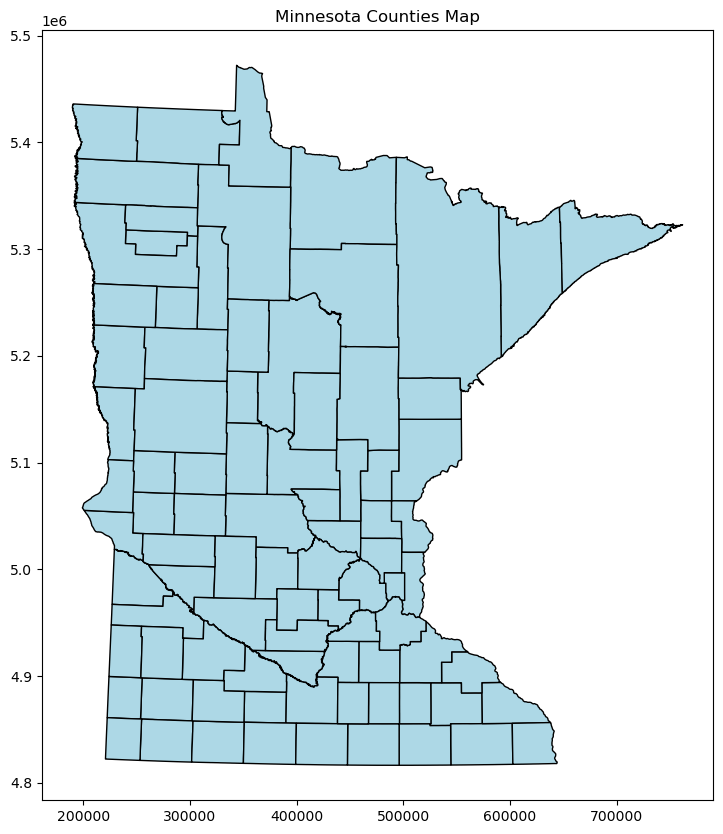

In [17]:

import geopandas as gpd

import pandas as pd
import numpy as np
import json
import folium 

# URL to Minnesota counties shapefile for geo location

mn_counties = gpd.read_file('mn_shp_bdry_counties.zip')
mn_counties.head(5)

fig, ax = plt.subplots(figsize=(10, 10))
mn_counties.plot(ax=ax, edgecolor='black', color='lightblue')
ax.set_title('Minnesota Counties Map')
plt.show()




In [36]:
import ee
import pprint
import geemap

Map = geemap.Map()

# My earth Engine token : '4/1AVGzR1CBsuAdpf9OOo5lXSia9B3Dmxpn5ebCTz993699GBRIOXDDelD91wI'

ee.Authenticate()
ee.Initialize()


# Pull satellite data
# Define years and months
years = range(2000, 2023)
months = range(2, 9) # Feb to Aug

# Function to get average value per county for a given image collection
def get_county_averages(collection, band, start_date, end_date, counties):
    image = collection.filterDate(start_date, end_date).mean().select(band)
   
    # Convert counties to EE feature collection
    ee_counties = ee.FeatureCollection([
        ee.Feature(ee.Geometry.Polygon(list(county.geometry.exterior.coords)), {'county_name': county['county_name'], 'fips': county['fips']})
        for _, county in counties.iterrows()
    ])
   
    # Reduce regions
    stats = image.reduceRegions(collection=ee_counties, reducer=ee.Reducer.mean(), scale=1000)
    results = stats.getInfo()
   
    data = []
    for feature in results['features']:
        props = feature['properties']
        data.append({
            'fips': props['fips'],
            'county_name': props['county_name'],
            'mean': props.get('mean', np.nan)
        })
    return pd.DataFrame(data)
    
# Initialize dataframes
ndvi_data = pd.DataFrame()
ssm_data = pd.DataFrame()
# MODIS NDVI Collection (MOD13A3: Monthly 1km)
modis_ndvi = ee.ImageCollection('MODIS/061/MOD13A3').filterDate('2020-02-01', '2020-02-02')
# GLDAS SSM Collection (SoilMoi0_10cm_inst for 0-10cm soil moisture)
gldas = ee.ImageCollection('NASA/GLDAS/V021/NOAH/G025/T3H').filterDate('2020-02-01', '2020-02-02')


vis_params = {'bands': ['SoilMoi0_10cm_inst'], 'min': 0, 'max': 0.3}

image = gldas.first()
Map.addLayer(image, vis_params, 'First Image')
Map
gldas.first()

In [58]:
import ee
import pprint
import geemap
import pandas as pd  # Ensure pd is imported for DataFrames
from tqdm import tqdm  # For progress bar to improve long loops
from IPython.display import display  # For displaying the map
import time  # For optional sleep if rate-limited

# Authenticate and initialize EE (use your token if needed, but ee.Authenticate() handles it)
ee.Authenticate(auth_mode='notebook')  # Better for notebooks
ee.Initialize()

# Assuming mn_counties is a GeoPandas DataFrame loaded earlier with columns like 'COUNTY_NAM', 'COUNTY_FIP', 'geometry'
# Reproject to EPSG:4326 (WGS84 lat/long) for EE compatibility
mn_counties = mn_counties.to_crs(epsg=4326)

# Simplify geometries to reduce vertices and payload size (tolerance in degrees, ~1km)
mn_counties['geometry'] = mn_counties['geometry'].simplify(tolerance=0.01)

# Pull satellite data with improvements: Add progress bar, handle potential empty collections
years = range(2010, 2023)
months = range(2, 9)  # Feb to Aug

# Function to get average value per county for a given image collection
def get_county_averages(collection, band, start_date, end_date, counties):
    try:
        image = collection.filterDate(start_date, end_date).mean().select(band)
        # Check if image is not null (handle empty collections)
        if image.bandNames().size().getInfo() == 0:
            print(f"No data for {band} between {start_date.format().getInfo()} and {end_date.format().getInfo()}")
            return pd.DataFrame()  # Return empty DF if no data
        
        # Convert counties to EE feature collection in batches to avoid payload limit
        data = []
        batch_size = 20  # Adjust if needed; smaller batches for complex geometries
        for i in range(0, len(counties), batch_size):
            batch_counties = counties.iloc[i:i+batch_size]
            
            # Handle Polygon and MultiPolygon
            def create_geom(geom):
                if geom.geom_type == 'Polygon':
                    return ee.Geometry.Polygon(list(geom.exterior.coords))
                elif geom.geom_type == 'MultiPolygon':
                    return ee.Geometry.MultiPolygon([[list(poly.exterior.coords)] for poly in geom.geoms])  # Assuming no holes
                else:
                    raise ValueError(f"Unsupported geometry type: {geom.geom_type}")
            
            ee_counties = ee.FeatureCollection([
                ee.Feature(create_geom(county.geometry), {'county_name': county['COUNTY_NAM'], 'fips': '27' + str(county['COUNTY_FIP']).zfill(3)})
                for _, county in batch_counties.iterrows()
            ])
            
            # Reduce regions
            stats = image.reduceRegions(collection=ee_counties, reducer=ee.Reducer.mean(), scale=1000)
            results = stats.getInfo()
            
            for feature in results['features']:
                props = feature['properties']
                mean_val = props.get('mean', float('nan')) if 'mean' in props else float('nan')
                data.append({
                    'fips': props['fips'],
                    'county_name': props['county_name'],
                    'mean': mean_val
                })
            # Optional: Sleep to avoid rate limits
            time.sleep(0.5)
        
        return pd.DataFrame(data)
    except Exception as e:
        print(f"Error processing {band} for dates {start_date.format().getInfo()} to {end_date.format().getInfo()}: {e}")
        return pd.DataFrame()  # Return empty on error

# Initialize dataframes
ndvi_data = pd.DataFrame()
ssm_data = pd.DataFrame()

# MODIS NDVI Collection (MOD13A3: Monthly 1km) - Full collection, no pre-filter
modis_ndvi = ee.ImageCollection('MODIS/061/MOD13A3')

# GLDAS SSM Collection (SoilMoi0_10cm_inst for 0-10cm soil moisture) - Full collection
gldas = ee.ImageCollection('NASA/GLDAS/V021/NOAH/G025/T3H')

# Loop with progress bar for better UX (23 years * 7 months = 161 iterations per dataset)
total_iterations = len(years) * len(months) * 2  # *2 for NDVI and SSM
with tqdm(total=total_iterations, desc="Processing Months") as pbar:
    for year in years:
        for month in months:
            start_date = ee.Date.fromYMD(year, month, 1)
            end_date = start_date.advance(1, 'month')
            
            # Get NDVI
            ndvi_monthly = get_county_averages(modis_ndvi, 'NDVI', start_date, end_date, mn_counties)
            if not ndvi_monthly.empty:
                ndvi_monthly['year'] = year
                ndvi_monthly['month'] = month
                ndvi_data = pd.concat([ndvi_data, ndvi_monthly])
            pbar.update(1)
            
            # Get SSM (average daily to monthly)
            ssm_monthly = get_county_averages(gldas, 'SoilMoi0_10cm_inst', start_date, end_date, mn_counties)
            if not ssm_monthly.empty:
                ssm_monthly['year'] = year
                ssm_monthly['month'] = month
                ssm_data = pd.concat([ssm_data, ssm_monthly])
            pbar.update(1)

# Pivot to have time-series columns
if not ndvi_data.empty:
    ndvi_pivot = ndvi_data.pivot_table(index=['fips', 'county_name'], columns=['year', 'month'], values='mean', aggfunc='first')
    ndvi_pivot.to_csv('mn_county_ndvi_2000_2022.csv')
else:
    print("No NDVI data collected.")

if not ssm_data.empty:
    ssm_pivot = ssm_data.pivot_table(index=['fips', 'county_name'], columns=['year', 'month'], values='mean', aggfunc='first')
    ssm_pivot.to_csv('mn_county_ssm_2000_2022.csv')
else:
    print("No SSM data collected.")

# Display the first image from GLDAS for verification
Map = geemap.Map(center=[46.4, -94.5], zoom=6)  # Center on Minnesota
vis_params = {'bands': ['SoilMoi0_10cm_inst'], 'min': 0, 'max': 50, 'palette': ['blue', 'cyan', 'green', 'yellow', 'red']}  # Adjusted max for kg/m3

# Get a sample image (first from a specific date)
sample_gldas = ee.ImageCollection('NASA/GLDAS/V021/NOAH/G025/T3H').filterDate('2020-02-01', '2020-02-02')
image = sample_gldas.first()
Map.addLayer(image, vis_params, 'First GLDAS Image')

# Print image info
print("First GLDAS Image Info:")
pprint.pprint(image.getInfo())

# Display the interactive map
display(Map)



Processing Months: 100%|███████████████████████████████████████████████████████████| 182/182 [3:08:53<00:00, 62.27s/it]


First GLDAS Image Info:
{'bands': [{'crs': 'EPSG:4326',
            'crs_transform': [0.25, 0, -180, 0, -0.25, 90],
            'data_type': {'precision': 'float', 'type': 'PixelType'},
            'dimensions': [1440, 600],
            'id': 'Albedo_inst'},
           {'crs': 'EPSG:4326',
            'crs_transform': [0.25, 0, -180, 0, -0.25, 90],
            'data_type': {'precision': 'float', 'type': 'PixelType'},
            'dimensions': [1440, 600],
            'id': 'AvgSurfT_inst'},
           {'crs': 'EPSG:4326',
            'crs_transform': [0.25, 0, -180, 0, -0.25, 90],
            'data_type': {'precision': 'float', 'type': 'PixelType'},
            'dimensions': [1440, 600],
            'id': 'CanopInt_inst'},
           {'crs': 'EPSG:4326',
            'crs_transform': [0.25, 0, -180, 0, -0.25, 90],
            'data_type': {'precision': 'float', 'type': 'PixelType'},
            'dimensions': [1440, 600],
            'id': 'ECanop_tavg'},
           {'crs': 'EPSG:4326',


Map(center=[46.4, -94.5], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topright',…

In [61]:
# Display the first image from GLDAS for verification
Map = geemap.Map(center=[46.4, -94.5], zoom=6)  # Center on Minnesota
vis_params = {'bands': ['SoilMoi0_10cm_inst'], 'min': 0, 'max': 50, 'palette': ['blue', 'cyan', 'green', 'yellow', 'red']}  # Adjusted max for kg/m3

# Get a sample image (first from a specific date)
sample_gldas = ee.ImageCollection('NASA/GLDAS/V021/NOAH/G025/T3H').filterDate('2020-02-01', '2020-02-02')
image = sample_gldas.first()
Map.addLayer(image, vis_params, 'First GLDAS Image')

# Print image info
print("First GLDAS Image Info:")
pprint.pprint(image.getInfo())

# Display the interactive map
display(Map)

First GLDAS Image Info:
{'bands': [{'crs': 'EPSG:4326',
            'crs_transform': [0.25, 0, -180, 0, -0.25, 90],
            'data_type': {'precision': 'float', 'type': 'PixelType'},
            'dimensions': [1440, 600],
            'id': 'Albedo_inst'},
           {'crs': 'EPSG:4326',
            'crs_transform': [0.25, 0, -180, 0, -0.25, 90],
            'data_type': {'precision': 'float', 'type': 'PixelType'},
            'dimensions': [1440, 600],
            'id': 'AvgSurfT_inst'},
           {'crs': 'EPSG:4326',
            'crs_transform': [0.25, 0, -180, 0, -0.25, 90],
            'data_type': {'precision': 'float', 'type': 'PixelType'},
            'dimensions': [1440, 600],
            'id': 'CanopInt_inst'},
           {'crs': 'EPSG:4326',
            'crs_transform': [0.25, 0, -180, 0, -0.25, 90],
            'data_type': {'precision': 'float', 'type': 'PixelType'},
            'dimensions': [1440, 600],
            'id': 'ECanop_tavg'},
           {'crs': 'EPSG:4326',


Map(center=[46.4, -94.5], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topright',…

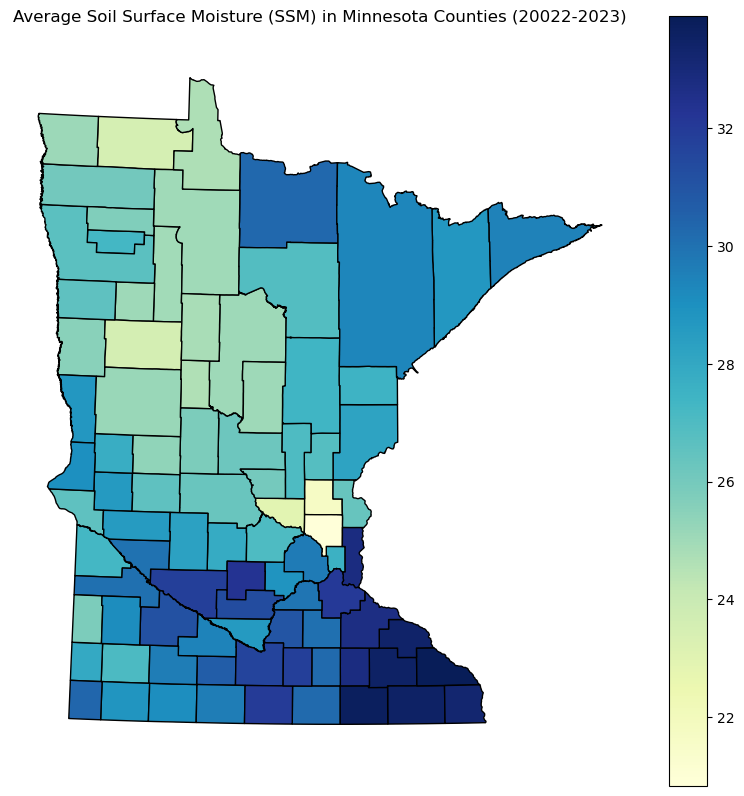

In [62]:
# mn_county_ndvi_2000_2022.csv
# mn_county_ssm_2000_2022.csv

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the SSM CSV
ssm_df = pd.read_csv('mn_county_ssm_2010_2022.csv')

# Rename the first two columns since they are unnamed in the CSV
ssm_df.columns = ['fips', 'county_name'] + list(ssm_df.columns[2:])

# Load the shapefile from zip (specify the shp inside)
mn_counties = gpd.read_file('Minnesota/County_Boundaries_in_Minnesota.shp')

# Prepare FIPS in mn_counties (MN state code 27 + 3-digit county code)
mn_counties['fips'] = '27' + mn_counties['COUNTY_FIP'].astype(str).str.zfill(3)
mn_counties['county_name'] = mn_counties['COUNTY_NAM']

# Reset index for ssm_df to make fips and county_name columns
ssm_df = ssm_df.reset_index()

# Compute average SSM per county
ssm_df['avg_ssm'] = ssm_df.mean(axis=1, numeric_only=True)

# Merge on 'fips'
merged = mn_counties.merge(ssm_df[['fips', 'avg_ssm']], on='fips', how='left')

# Plot choropleth map
fig, ax = plt.subplots(figsize=(10, 10))
merged.plot(column='avg_ssm', ax=ax, legend=True, cmap='YlGnBu', edgecolor='black', missing_kwds={'color': 'lightgrey'})
ax.set_title('Average Soil Surface Moisture (SSM) in Minnesota Counties (20022-2023)')
plt.axis('off')
plt.show()

In [63]:
ssm_df.head(5)

,index,fips,county_name,2010,2010.1,2010.2,2010.3,2010.4,2010.5,2010.6,...,2021.5,2021.6,2022,2022.1,2022.2,2022.3,2022.4,2022.5,2022.6,avg_ssm
0,0,month,NaN,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,...,7.000000,8.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,4.945652
1,1,fips,county_name,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
2,2,27001,Aitkin,33.798257,31.843019,23.913524,26.223306,26.590999,25.053066,24.494810,...,17.619179,18.646991,38.685230,40.454439,31.699320,27.760702,26.290877,24.367360,22.151081,27.414439
3,3,27003,Anoka,34.353172,25.259322,19.211949,19.916694,22.790019,21.547322,20.677023,...,9.616133,11.148594,22.428474,24.644967,15.087113,15.882569,14.718324,12.592203,12.529646,20.830644
4,4,27005,Becker,24.555826,30.318497,21.290868,24.737997,24.178712,22.763117,21.103657,...,9.486201,14.370224,32.818110,36.813738,29.584411,24.967974,22.399805,20.888664,16.936090,23.584804
